# Import Libraries

In [54]:
import datetime as datetime
from feature_extraction.indicator_features import *
from feature_extraction.price_features import *
from feature_extraction.trader_features import *
import matplotlib.pyplot as plt
from models.model import *
# import mplfinance as mpf
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
import pytse_client as tse
from pytse_client.download import download_financial_indexes
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from zigzag import *
# from labeling.zigzag import peak_valley_pivots

# Import Data

In [55]:
tse.download(
    symbols = ['فولاد'],
    adjust = True, 
    write_to_csv = True, 
    include_jdate = True
)
ticker = tse.Ticker(
    symbol = 'فولاد',  
    adjust = True
)
ticker_history = ticker.history

ticker_history = ticker_history[ticker_history.columns[:-1].insert(0, ticker_history.columns[-1]).to_list()] # change location of jdate

print(f'Shape of Folad price history: {ticker_history.shape}')
print(50 * '-')
print(f'{ticker_history.info()}')
print(50 * '-')
ticker_history.head()

Shape of Folad price history: (3525, 11)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3525 entries, 0 to 3524
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   jdate      3525 non-null   object        
 1   date       3525 non-null   datetime64[ns]
 2   open       3525 non-null   float64       
 3   high       3525 non-null   float64       
 4   low        3525 non-null   float64       
 5   adjClose   3525 non-null   float64       
 6   value      3525 non-null   int64         
 7   volume     3525 non-null   int64         
 8   count      3525 non-null   int64         
 9   yesterday  3525 non-null   float64       
 10  close      3525 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(3), object(1)
memory usage: 303.1+ KB
None
--------------------------------------------------


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0


In [56]:
market_index = download_financial_indexes(
    symbols = 'شاخص كل', 
    write_to_csv = True
)
market_index = market_index['شاخص كل']
market_index.rename(
    columns = {'value': 'TEDPIX'}, 
    inplace = True
)

print(f'Shape of TEDPIX: {market_index.shape}')
market_index.head()

Shape of TEDPIX: (3439, 2)


,TEDPIX,date
0,9248.9,2008-12-04
1,9248.9,2008-12-05
2,9178.3,2008-12-06
3,9130.5,2008-12-07
4,9089.2,2008-12-08


# Data Preprocessing

In [57]:
ticker_traders_types = ticker.client_types
ticker_traders_types = ticker_traders_types.iloc[::-1]
ticker_traders_types.reset_index(
    drop = True,
    inplace = True
)
ticker_traders_types['date'] = ticker_traders_types['date'].apply(
    lambda x: datetime.datetime.strptime(x, '%Y%m%d')
)
ticker_traders_types.iloc[:, 1:] = ticker_traders_types.iloc[:, 1:].astype('float')

print(f"Shape of Folad's client history: {ticker_traders_types.shape}")
print(50 * '-')
print(f'{ticker_traders_types.info()}')
print(50 * '-')
ticker_traders_types.head()

Shape of Folad's client history: (3140, 18)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         3140 non-null   datetime64[ns]
 1   individual_buy_count         3140 non-null   float64       
 2   corporate_buy_count          3140 non-null   float64       
 3   individual_sell_count        3140 non-null   float64       
 4   corporate_sell_count         3140 non-null   float64       
 5   individual_buy_vol           3140 non-null   float64       
 6   corporate_buy_vol            3140 non-null   float64       
 7   individual_sell_vol          3140 non-null   float64       
 8   corporate_sell_vol           3140 non-null   float64       
 9   individual_buy_value         3140 non-null   float64       
 10  corporate_buy

,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change
0,2008-11-26,14.0,2.0,4.0,1.0,106338.0,20010.0,126338.0,10.0,2.489373e+08,4.684412e+07,295757258.0,2.412000e+04,2341.000000,2341.0,2341.035482,2412.000000,-20000.0
1,2008-11-29,116.0,175.0,3.0,2.0,4718258.0,33691903.0,121402.0,38288759.0,1.498023e+10,1.077130e+11,284080680.0,1.224092e+11,3174.949168,2340.0,3196.999767,3196.999795,4596856.0
2,2008-11-30,10.0,2.0,1.0,1.0,87219.0,12791.0,100000.0,10.0,2.040052e+08,2.991886e+07,233900000.0,2.410000e+04,2339.000000,2339.0,2339.055508,2410.000000,-12781.0
3,2008-12-01,8.0,1.0,5.0,1.0,128666.0,10.0,128666.0,10.0,3.008211e+08,2.409000e+04,300821108.0,2.409000e+04,2338.000000,2338.0,2409.000000,2409.000000,0.0
4,2008-12-02,7.0,1.0,1.0,0.0,18553.0,10000.0,28553.0,0.0,4.335836e+07,2.337000e+07,66728361.0,0.000000e+00,2337.000000,2337.0,2337.000000,NaN,-10000.0


In [58]:
ticker_history = ticker_history.merge(
    market_index, 
    how = 'left', 
    on = 'date'
)
ticker_history.head()

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN
4,1385-12-26,2007-03-17,16.0,16.0,16.0,16.0,28239006789,14877283,1514,16.0,16.0,NaN


In [59]:
# # plt.figure(figsize = (10, 50))
# # plt.tight_layout()
# dff = ticker_history[['date', 'open', 'high', 'low', 'close','volume']].set_index('date')

# fig, ax = mpf.plot(
#     dff,
#     title = 'Mobarakeh Steel  Stock Price',
#     volume = True,
#     type = 'candle',
#     # style = 'yahoo',
#     figratio = (18,10),
#     figscale = 1.5,
#     datetime_format = '%Y-%m-%d',
#     # marketcolor_overrides = ,
#     tight_layout = True,
#     returnfig=True
#     # tight_layout = True
# )
# ax = ax[0]
# ax.set_yscale('log')

In [60]:
# def plot_chart(data, n, ticker):
    
#     # Filter number of observations to plot
#     data = data.iloc[-n:]
    
#     # Create figure and set axes for subplots
#     fig = plt.figure()
#     fig.set_size_inches((20, 16))
#     ax_candle = fig.add_axes((0, 0.72, 1, 0.32))
#     ax_macd = fig.add_axes((0, 0.48, 1, 0.2), sharex=ax_candle)
#     ax_rsi = fig.add_axes((0, 0.24, 1, 0.2), sharex=ax_candle)
#     ax_vol = fig.add_axes((0, 0, 1, 0.2), sharex=ax_candle)
    
#     # Format x-axis ticks as dates
#     ax_candle.xaxis_date()
    
#     # Get nested list of date, open, high, low and close prices
#     ohlc = []
#     for date, row in data.iterrows():
#         openp, highp, lowp, closep = row[:4]
#         ohlc.append([date2num(date), openp, highp, lowp, closep])
 
#     # Plot candlestick chart
#     ax_candle.plot(data.index, data["ma10"], label="MA10")
#     ax_candle.plot(data.index, data["ma30"], label="MA30")
#     candlestick_ohlc(ax_candle, ohlc, colorup="g", colordown="r", width=0.8)
#     ax_candle.legend()
    
#     # Plot MACD
#     ax_macd.plot(data.index, data["macd"], label="macd")
#     ax_macd.bar(data.index, data["macd_hist"] * 3, label="hist")
#     ax_macd.plot(data.index, data["macd_signal"], label="signal")
#     ax_macd.legend()
    
#     # Plot RSI
#     # Above 70% = overbought, below 30% = oversold
#     ax_rsi.set_ylabel("(%)")
#     ax_rsi.plot(data.index, [70] * len(data.index), label="overbought")
#     ax_rsi.plot(data.index, [30] * len(data.index), label="oversold")
#     ax_rsi.plot(data.index, data["rsi"], label="rsi")
#     ax_rsi.legend()
    
#     # Show volume in millions
#     ax_vol.bar(data.index, data["Volume"] / 1000000)
#     ax_vol.set_ylabel("(Million)")
   
#     # Save the chart as PNG
#     fig.savefig("charts/" + ticker + ".png", bbox_inches="tight")
    
#     plt.show()

# Feature Extraction

In [61]:
calenderFeatures = calender_features(ticker_history)
candelFeatures = candlestick_feature(ticker_history)
prpFeatures = prp_based(ticker_history)
retFeatures = ret_based(ticker_history)
shiftFeatures = shift_data(ticker_history)
wghtFeatures = weight_feature(ticker_history)

priceFeatures = pd.concat(
    [
        ticker_history,
        calenderFeatures,
        candelFeatures,
        prpFeatures,
        retFeatures,
        shiftFeatures,
        wghtFeatures
    ], axis = 1
)

print(f'Shape of price features: {priceFeatures.shape}')
priceFeatures.head()

Shape of price features: (3525, 132)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,prc_chang_1d,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d
0,1385-12-20,2007-03-11,16.0,16.0,16.0,16.0,889437216900,468077431,7736,16.0,16.0,NaN,1385,4,12,20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1385-12-21,2007-03-12,16.0,16.0,16.0,16.0,193879458000,100041000,9214,16.0,16.0,NaN,1385,4,12,21,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.0,16.0,8.894372e+11,468077431.0,7736.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1385-12-22,2007-03-13,16.0,16.0,16.0,16.0,249241504527,126270939,5862,16.0,16.0,NaN,1385,4,12,22,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.0,16.0,1.938795e+11,100041000.0,9214.0,16.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1385-12-23,2007-03-14,16.0,16.0,16.0,16.0,51666379451,26705128,1901,16.0,16.0,NaN,1385,4,12,23,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-0.0625,0.0,0.0,0.0625,0.0,-0.0625,0.0,0.0,0.0625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,15.0,16.0,16.0,16.0,16.0,16.0,15.0,16.0,16.0,16.0,16.0,1.066667,1.066667,NaN,NaN,NaN,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,0,16.0,16.0,16.

In [62]:
traderFeatures = ticker_traders_types.merge(
    indv_nonindv_features(ticker_traders_types),
    how = 'left',
    on = 'date'
)

print(f'Shape of trader features: {traderFeatures.shape}')
traderFeatures.head()

Shape of trader features: (3140, 42)


,date,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m
0,2008-11-26,14.0,2.0,4.0,1.0,106338.0,20010.0,126338.0,10.0,2.489373e+08,4.684412e+07,295757258.0,2.412000e+04,2341.000000,2341.0,2341.035482,2412.000000,-20000.0,-4.682000e+07,1.778123e+07,73939314.5,0.240484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.646302,1.209462,0.392173,-1.281292e+10,0.646302,1.209462,0.392173
1,2008-11-29,116.0,175.0,3.0,2.0,4718258.0,33691903.0,121402.0,38288759.0,1.498023e+10,1.077130e+11,284080680.0,1.224092e+11,3174.949168,2340.0,3196.999767,3196.999795,4596856.0,1.469615e+10,1.291399e+08,94693560.0,1.363767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,4.693901,1.548950,2.223985,-1.281292e+10,4.693901,1.548950,2.223985
2,2008-11-30,10.0,2.0,1.0,1.0,87219.0,12791.0,100000.0,10.0,2.040052e+08,2.991886e+07,233900000.0,2.410000e+04,2339.000000,2339.0,2339.055508,2410.000000,-12781.0,-2.989476e+07,2.040052e+07,233900000.0,0.087219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.741506,3.826019,0.142234,-1.281292e+10,0.741506,3.826019,0.142234
3,2008-12-01,8.0,1.0,5.0,1.0,128666.0,10.0,128666.0,10.0,3.008211e+08,2.409000e+04,300821108.0,2.409000e+04,2338.000000,2338.0,2409.000000,2409.000000,0.0,0.000000e+00,3.760264e+07,60164221.6,0.625000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,1.366759,0.984136,1.019229,-1.281292e+10,1.366759,0.984136,1.019229
4,2008-12-02,7.0,1.0,1.0,0.0,18553.0,10000.0,28553.0,0.0,4.335836e+07,2.337000e+07,66728361.0,0.000000e+00,2337.000000,2337.0,2337.000000,NaN,-10000.0,-2.337000e+07,6.194052e+06,66728361.0,0.092825,1.459606e+10,0.146696,0.630196,0.192639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.281292e+10,0.225138,1.091509,0.151376,-1.281292e+10,0.225138,1.091509,0.151376


In [63]:
bbFeatures = BB(ticker_history)
ichiFeatures = ICHIMOKU(ticker_history)
emaFeatures = EMA(ticker_history)
macdFeatures = MACD(ticker_history)
smaFeatures = SMA(ticker_history)
stochasticFeatures = STOCHASTIC(ticker_history)
rsiFeatures = RSI(ticker_history)

indicatorFeatures = pd.concat(
    [
        bbFeatures,
        ichiFeatures,
        emaFeatures,
        macdFeatures,
        smaFeatures,
        stochasticFeatures,
        rsiFeatures,
    ], axis = 1
)

print(f'Shape of indicator features: {indicatorFeatures.shape}')
indicatorFeatures.head()

Shape of indicator features: (3525, 43)


,BB_bbh,BB_bbl,BB_buy,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_buy,EMA_position,MACD,MACD_diff,MACD_signal,MACD_buy,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_buy,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_buy,STOCH_position,RSI,RSI_buy,RSI_position
0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,16.0,NaN,NaN,NaN,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
features_extracted = pd.concat(
    [
        priceFeatures,
        indicatorFeatures
    ],
    axis = 1
)
features_extracted = features_extracted.merge(
    traderFeatures,
    how = 'right',
    on = 'date'
)
print(f'shape of features after concatenation: {features_extracted.shape}')

features_extracted.dropna(
    axis = 'columns', 
    thresh = len(features_extracted) - 385,
    inplace = True
)
print(f'shape of features after drop non-essential columns: {features_extracted.shape}')
print(f'names of the columns that dropped: {(indicatorFeatures.columns.union(priceFeatures.columns)).difference(features_extracted.columns).to_list()}')

features_extracted.dropna(
    axis = 'index', 
    how = 'any',
    inplace = True
)
features_extracted.reset_index(inplace = True, drop = True)

print(f'shape of features after drop non-essential rows: {features_extracted.shape}')
features_extracted

shape of features after concatenation: (3140, 216)
shape of features after drop non-essential columns: (3140, 210)
names of the columns that dropped: ['BB_buy', 'EMA_buy', 'MACD_buy', 'RSI_buy', 'SMA_buy', 'STOCH_buy']
shape of features after drop non-essential rows: (2882, 210)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,prc_chang_1d,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m
0,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1388.0,1.0,2.0,14.0,2.0,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.00000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.000000,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.0,0.000000,0.000000,0.000000,0.000000,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0.0,0.0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,15.0,8518.1,3.055976e+09,2.308920e+09,2.399035e+09,2.330764e

# Data Labeling

In [65]:
pivots = pd.DataFrame(
    peak_valley_pivots(
        features_extracted['adjClose'].to_list(), 0.075, -0.075
    ),
    columns = ['label']
)

df = features_extracted.copy()
df['pivot'] = pivots

print(f'Number of each pivot {np.unique(pivots["label"], return_counts = True)}')

Number of each pivot (array([-1,  0,  1]), array([  64, 2756,   62], dtype=int64))


In [66]:
weight = [0] * len(df)

start_index = np.where(df['pivot'].isin([1, -1]))[0][0]
end_index = np.where(df['pivot'].isin([1, -1]))[0][-1]

# Iterate through the dataframe to label each row
for i in range(start_index, end_index + 1):
    if df.at[i, 'pivot'] == 1: # Uptrend
        # Find the previous pivot
        prev_pivot = 0
        for j in range(i - 1, start_index - 1, -1):
            if df.at[j, 'pivot'] == -1:
                prev_pivot = j
                break
        
        # Calculate the weight based on the slope of the trend line
        try:
            slope = (df.at[i, 'close'] - df.at[prev_pivot, 'close']) / (i - prev_pivot)
            slope_weight = 1 + slope / abs(slope)
        except:
            slope_weight = 0
        
        for z in range(prev_pivot, i):
            # Calculate the weight based on the length of the trend
            length = i - z
            length_weight = 1 + length / (end_index - start_index + 1)
            
            # Combine the two weights
            final_weight = slope_weight * length_weight
            
            # Label the data as 'buy' with the final weight
            weight[z] = final_weight * 1
    elif df.at[i, 'pivot'] == -1: # Downtrend
        # Find the previous pivot
        prev_pivot = 0
        for j in range(i - 1, start_index - 1, -1):
            if df.at[j, 'pivot'] == 1:
                prev_pivot = j
                break
        
        # Calculate the weight based on the slope of the trend line
        try:
            slope = (df.at[i, 'close'] - df.at[prev_pivot, 'close']) / (i - prev_pivot)
            slope_weight = -1 + slope / abs(slope)
        except:
            slope_weight = 0
        
        for z in range(prev_pivot, i):
            # Calculate the weight based on the length of the trend
            length = i - z
            length_weight = 1 + length / (end_index - start_index + 1)
            
            # Combine the two weights
            final_weight = slope_weight * length_weight
            
            # Label the data as 'sell' with the final weight
            weight[z] = final_weight * 1

# Add the labels to the dataframe
df['weight'] = weight
# df['weight'].fillna(0, inplace = True)

# Find the quantiles of the positive and negative labels
pos_quantiles = np.quantile(df[df['weight'] > 0]['weight'], [0.33])
neg_quantiles = np.quantile(df[df['weight'] < 0]['weight'], [0.66])

# Use np.where to apply conditions to the entire label column
df['cat_label'] = np.where(
                          df['weight'] >= pos_quantiles[0], 'buy',
                  np.where(
                          df['weight'] >= neg_quantiles[0], 'neutral', 'sell'
))
# df['cat_label'] = np.where(
#                           df['pivot'].isin([-1, 1]), 'pivot', df['cat_label']
# )

values, counts = np.unique(df['cat_label'], return_counts = True)
values = values.tolist()
counts = counts.tolist()
print(f'Number of members in each class:\n{values}\n{counts}')

df[['date', 'pivot', 'weight', 'cat_label']]

Number of members in each class:
['buy', 'neutral', 'sell']
[1043, 982, 857]


,date,pivot,weight,cat_label
0,2009-05-04,-1,2.009715,buy
1,2009-05-05,0,2.009022,buy
2,2009-05-30,0,2.008328,buy
3,2009-05-31,0,2.007634,buy
4,2009-06-01,0,2.006940,buy
...,...,...,...,...
2877,2023-01-11,0,0.000000,neutral
2878,2023-01-14,0,0.000000,neutral
2879,2023-01-16,0,0.000000,neutral
2880,2023-01-17,0,0.000000,neutral


In [67]:
init_features = features_extracted.merge(
    df[['date', 'pivot', 'weight', 'cat_label']],
    how = 'left',
    on = 'date'
)
print(f'Number of initial features: {init_features.shape}')
init_features

Number of initial features: (2882, 213)


,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,prc_chang_1d,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m,pivot,weight,cat_label
0,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1388.0,1.0,2.0,14.0,2.0,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.00000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.000000,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.0,0.000000,0.000000,0.000000,0.000000,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0.0,0.0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,15.0,8518.1,3.055976e+09,2.308920e+09

# Modeling

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    init_features.iloc[:, 2:-3].values, 
    init_features.iloc[:, -1].values, 
    shuffle = False, 
    random_state = 0
)

## Bayesian Optimization

Hyperparameters are selected by the Bayesian optimization method. <a href = 'https://www.kaggle.com/alirezahanifi/iran-stock-market-bayesian-optimization-part'>Link</a> to the notebook of this part of the code in Kaggle. 

In [69]:
# def rfcScore(
#     n_estimators,
#     min_samples_split,
#     min_samples_leaf,
#     max_depth):
    
#     n_estimators = int(n_estimators)
#     min_samples_split = int(min_samples_split)
#     min_samples_leaf = int(min_samples_leaf)
#     max_depth = int(max_depth)
    
#     params = {
#         'n_estimators': n_estimators,
#         'criterion': 'entropy',
#         'min_samples_split': min_samples_split,
#         'min_samples_leaf': min_samples_leaf,
#         'max_depth': max_depth,
#         'max_features': 'sqrt',
#         'n_jobs': -1,
#         'random_state': 1,
#         'class_weight': 'balanced_subsample'
#     }

#     rfc = RandomForestClassifier(
#         **params
#     )

#     score = cross_val_score(
#         rfc, 
#         X = X_train,
#         y = y_train,
#         scoring = 'f1_weighted'
#     ).mean()

#     return score

# def RFClf(train_data, train_label, test_data, test_label, params):
    
#     clf = RandomForestClassifier(
#         n_estimators = int(params['n_estimators']),
#         max_depth = int(params['max_depth']),
#         min_samples_leaf = int(params['min_samples_leaf']),
#         min_samples_split = int(params['min_samples_split']),
#         criterion = 'entropy',
#         class_weight = 'balanced_subsample',
#         random_state = 0
#     )

#     clf.fit(train_data, train_label)
    
#     trainPred = clf.predict(train_data)
#     testPred = clf.predict(test_data)

#     trainProb = clf.predict_proba(train_data)
#     testProb = clf.predict_proba(test_data)

#     featureImport = clf.feature_importances_

#     trainClassReport = metrics.classification_report(train_label, trainPred)
#     testClassReport = metrics.classification_report(test_label, testPred)

#     return trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport

# rfcBound = {
#     'n_estimators': (100, 200),
#     'min_samples_split': (2, 5),
#     'min_samples_leaf': (1, 5),
#     'max_depth': (4, 8)
# }
# optimizer = BayesianOptimization(
#     f = rfcScore, 
#     pbounds = rfcBound,
#     random_state = 1
# )
# optimizer.maximize(
#     init_points = 3,
#     n_iter = 5,
# )

# print(f"Selected parameters: {optimizer.max['params']}\n")

# trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport = RFClf(X_train, y_train, X_test, y_test, optimizer.max['params'])

# print(f'Training classification report:\n{trainClassReport}')
# print(f'Testing classification report:\n{testClassReport}')

# Model Evaluation and Results

In [70]:
trainPred, testPred, trainProb, testProb, featureImport, trainClassReport, testClassReport, \
    trainCM, testCM, classes = RFClf(X_train, y_train, X_test, y_test)

print(f'Training classification report:\n{trainClassReport}')
print(f'Testing classification report:\n{testClassReport}')

Training classification report:
              precision    recall  f1-score   support

         buy       0.91      0.86      0.89       827
     neutral       0.76      0.71      0.73       665
        sell       0.77      0.89      0.83       669

    accuracy                           0.82      2161
   macro avg       0.82      0.82      0.81      2161
weighted avg       0.82      0.82      0.82      2161

Testing classification report:
              precision    recall  f1-score   support

         buy       0.63      0.26      0.37       216
     neutral       0.57      0.51      0.54       317
        sell       0.35      0.65      0.46       188

    accuracy                           0.47       721
   macro avg       0.52      0.47      0.46       721
weighted avg       0.53      0.47      0.47       721



Text(0.5, 1.0, 'Confusion Matrix (test dataset)')

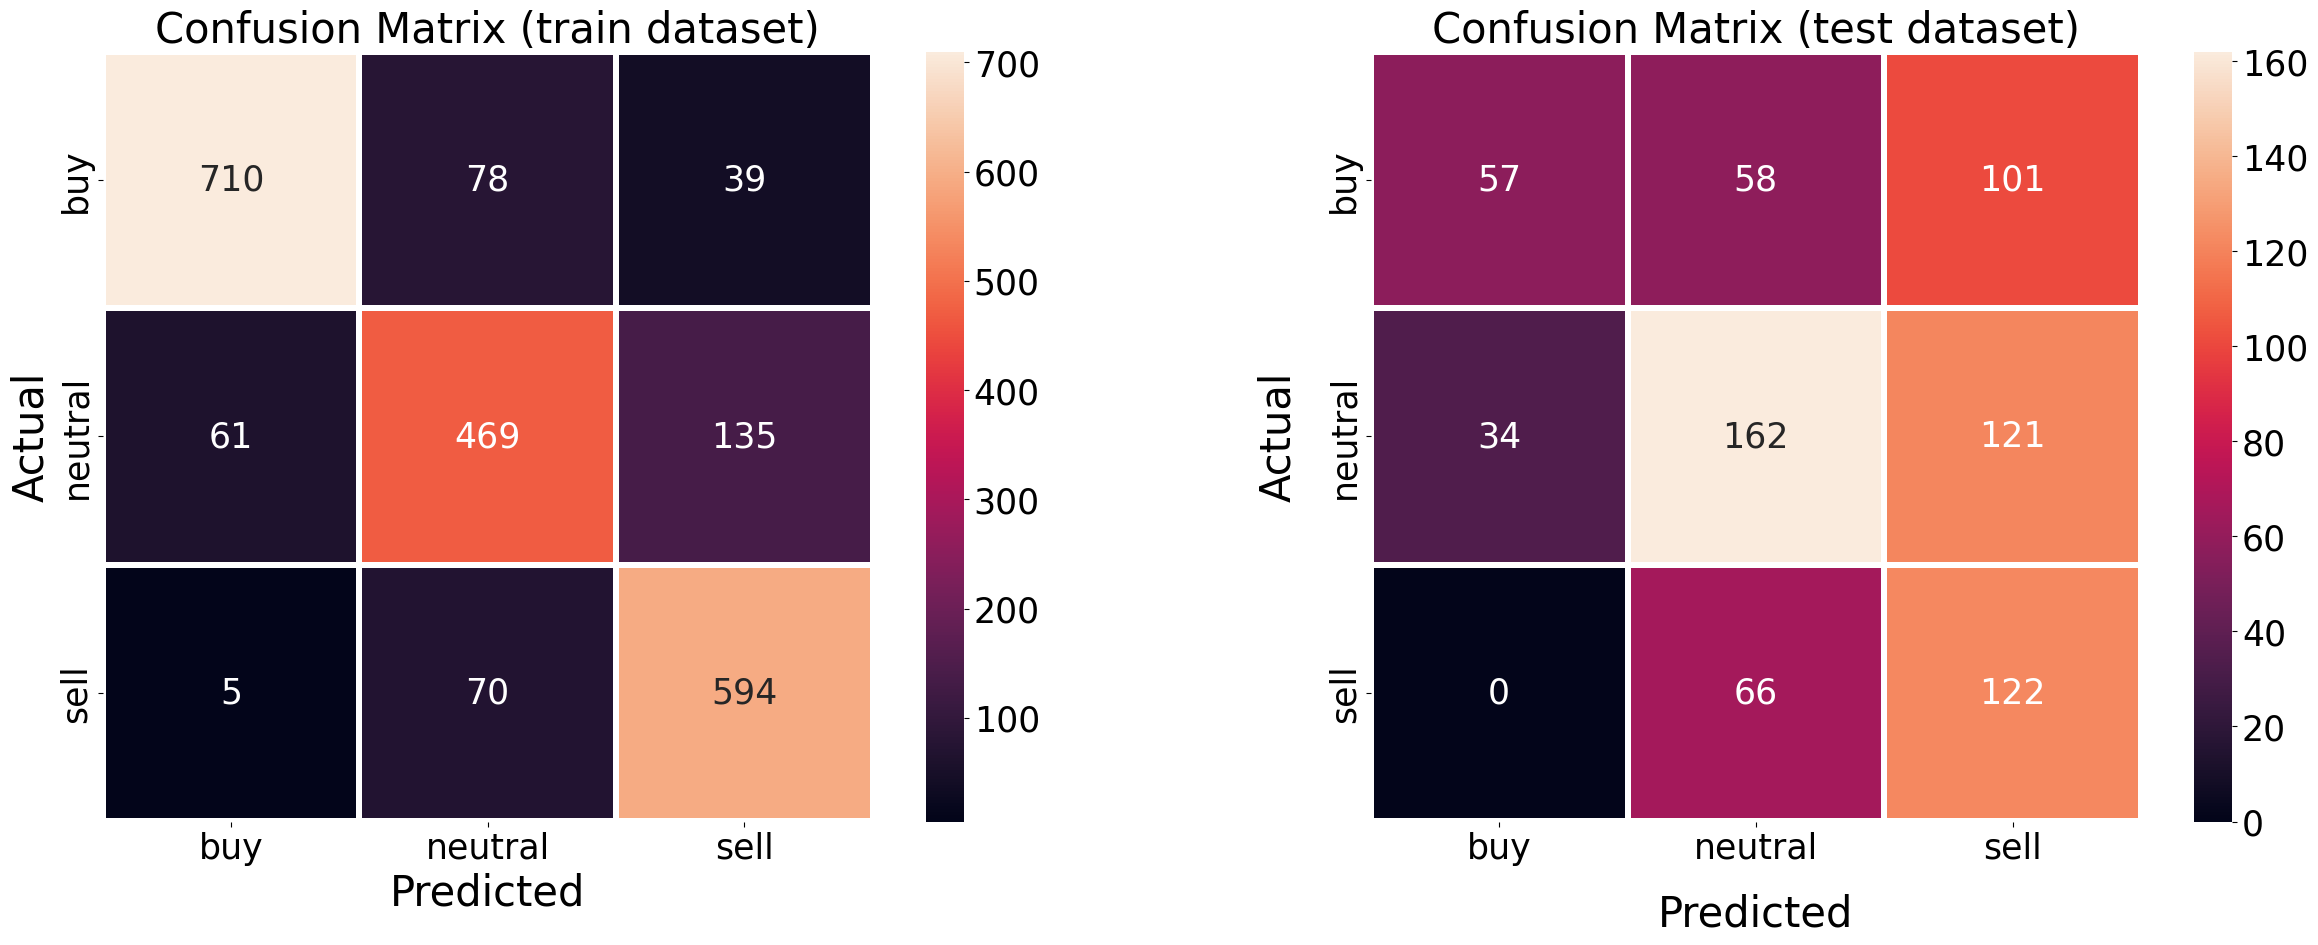

In [71]:
plt.figure(figsize=(30, 10))

plt.subplot(1, 2, 1)

ax = sns.heatmap(
    trainCM,
    annot = True,
    annot_kws = {'size': 25},
    fmt = 'd',
    linewidths = 4,
    square = True, 
    xticklabels = classes.tolist(),
    yticklabels = classes.tolist()
)
ax.set_xlabel('Predicted', fontsize = 30, labelpad = 5)
ax.set_ylabel('Actual', fontsize = 30, labelpad = 5)
ax.set_title('Confusion Matrix (train dataset)')

plt.subplot(1, 2, 2)

ax = sns.heatmap(
    testCM,
    annot = True,
    annot_kws = {'size': 25},
    fmt = 'd',
    linewidths = 4,
    square = True, 
    xticklabels = classes.tolist(),
    yticklabels = classes.tolist()
)
ax.set_xlabel('Predicted', fontsize = 30, labelpad = 20)
ax.set_ylabel('Actual', fontsize = 30, labelpad = 20)
ax.set_title('Confusion Matrix (test dataset)')

In [72]:
label_df = pd.DataFrame(
    np.concatenate((trainProb, testProb), axis = 0),
    columns = values
)
label_df = label_df[['buy', 'neutral', 'sell']]
label_df['pred_cat_label'] = np.concatenate((trainPred, testPred), axis = 0)
label_df.insert(0, 'jdate', init_features['jdate'])

# output for API 
try:
    label_df.to_csv('../api/inputs/output_for_API.csv', index = False) # if code run without docker
except: 
    label_df.to_csv('output_for_API.csv', index = False) # if code run in docker

label_df

,jdate,buy,neutral,sell,pred_cat_label
0,1388-02-14,0.660635,0.282552,0.056813,buy
1,1388-02-15,0.657712,0.280761,0.061526,buy
2,1388-03-09,0.549655,0.370023,0.080322,buy
3,1388-03-10,0.547877,0.385448,0.066675,buy
4,1388-03-11,0.514850,0.408587,0.076564,buy
...,...,...,...,...,...
2877,1401-10-21,0.457433,0.363389,0.179179,buy
2878,1401-10-24,0.474194,0.353980,0.171826,buy
2879,1401-10-26,0.459255,0.362732,0.178013,buy
2880,1401-10-27,0.461999,0.353870,0.184131,buy


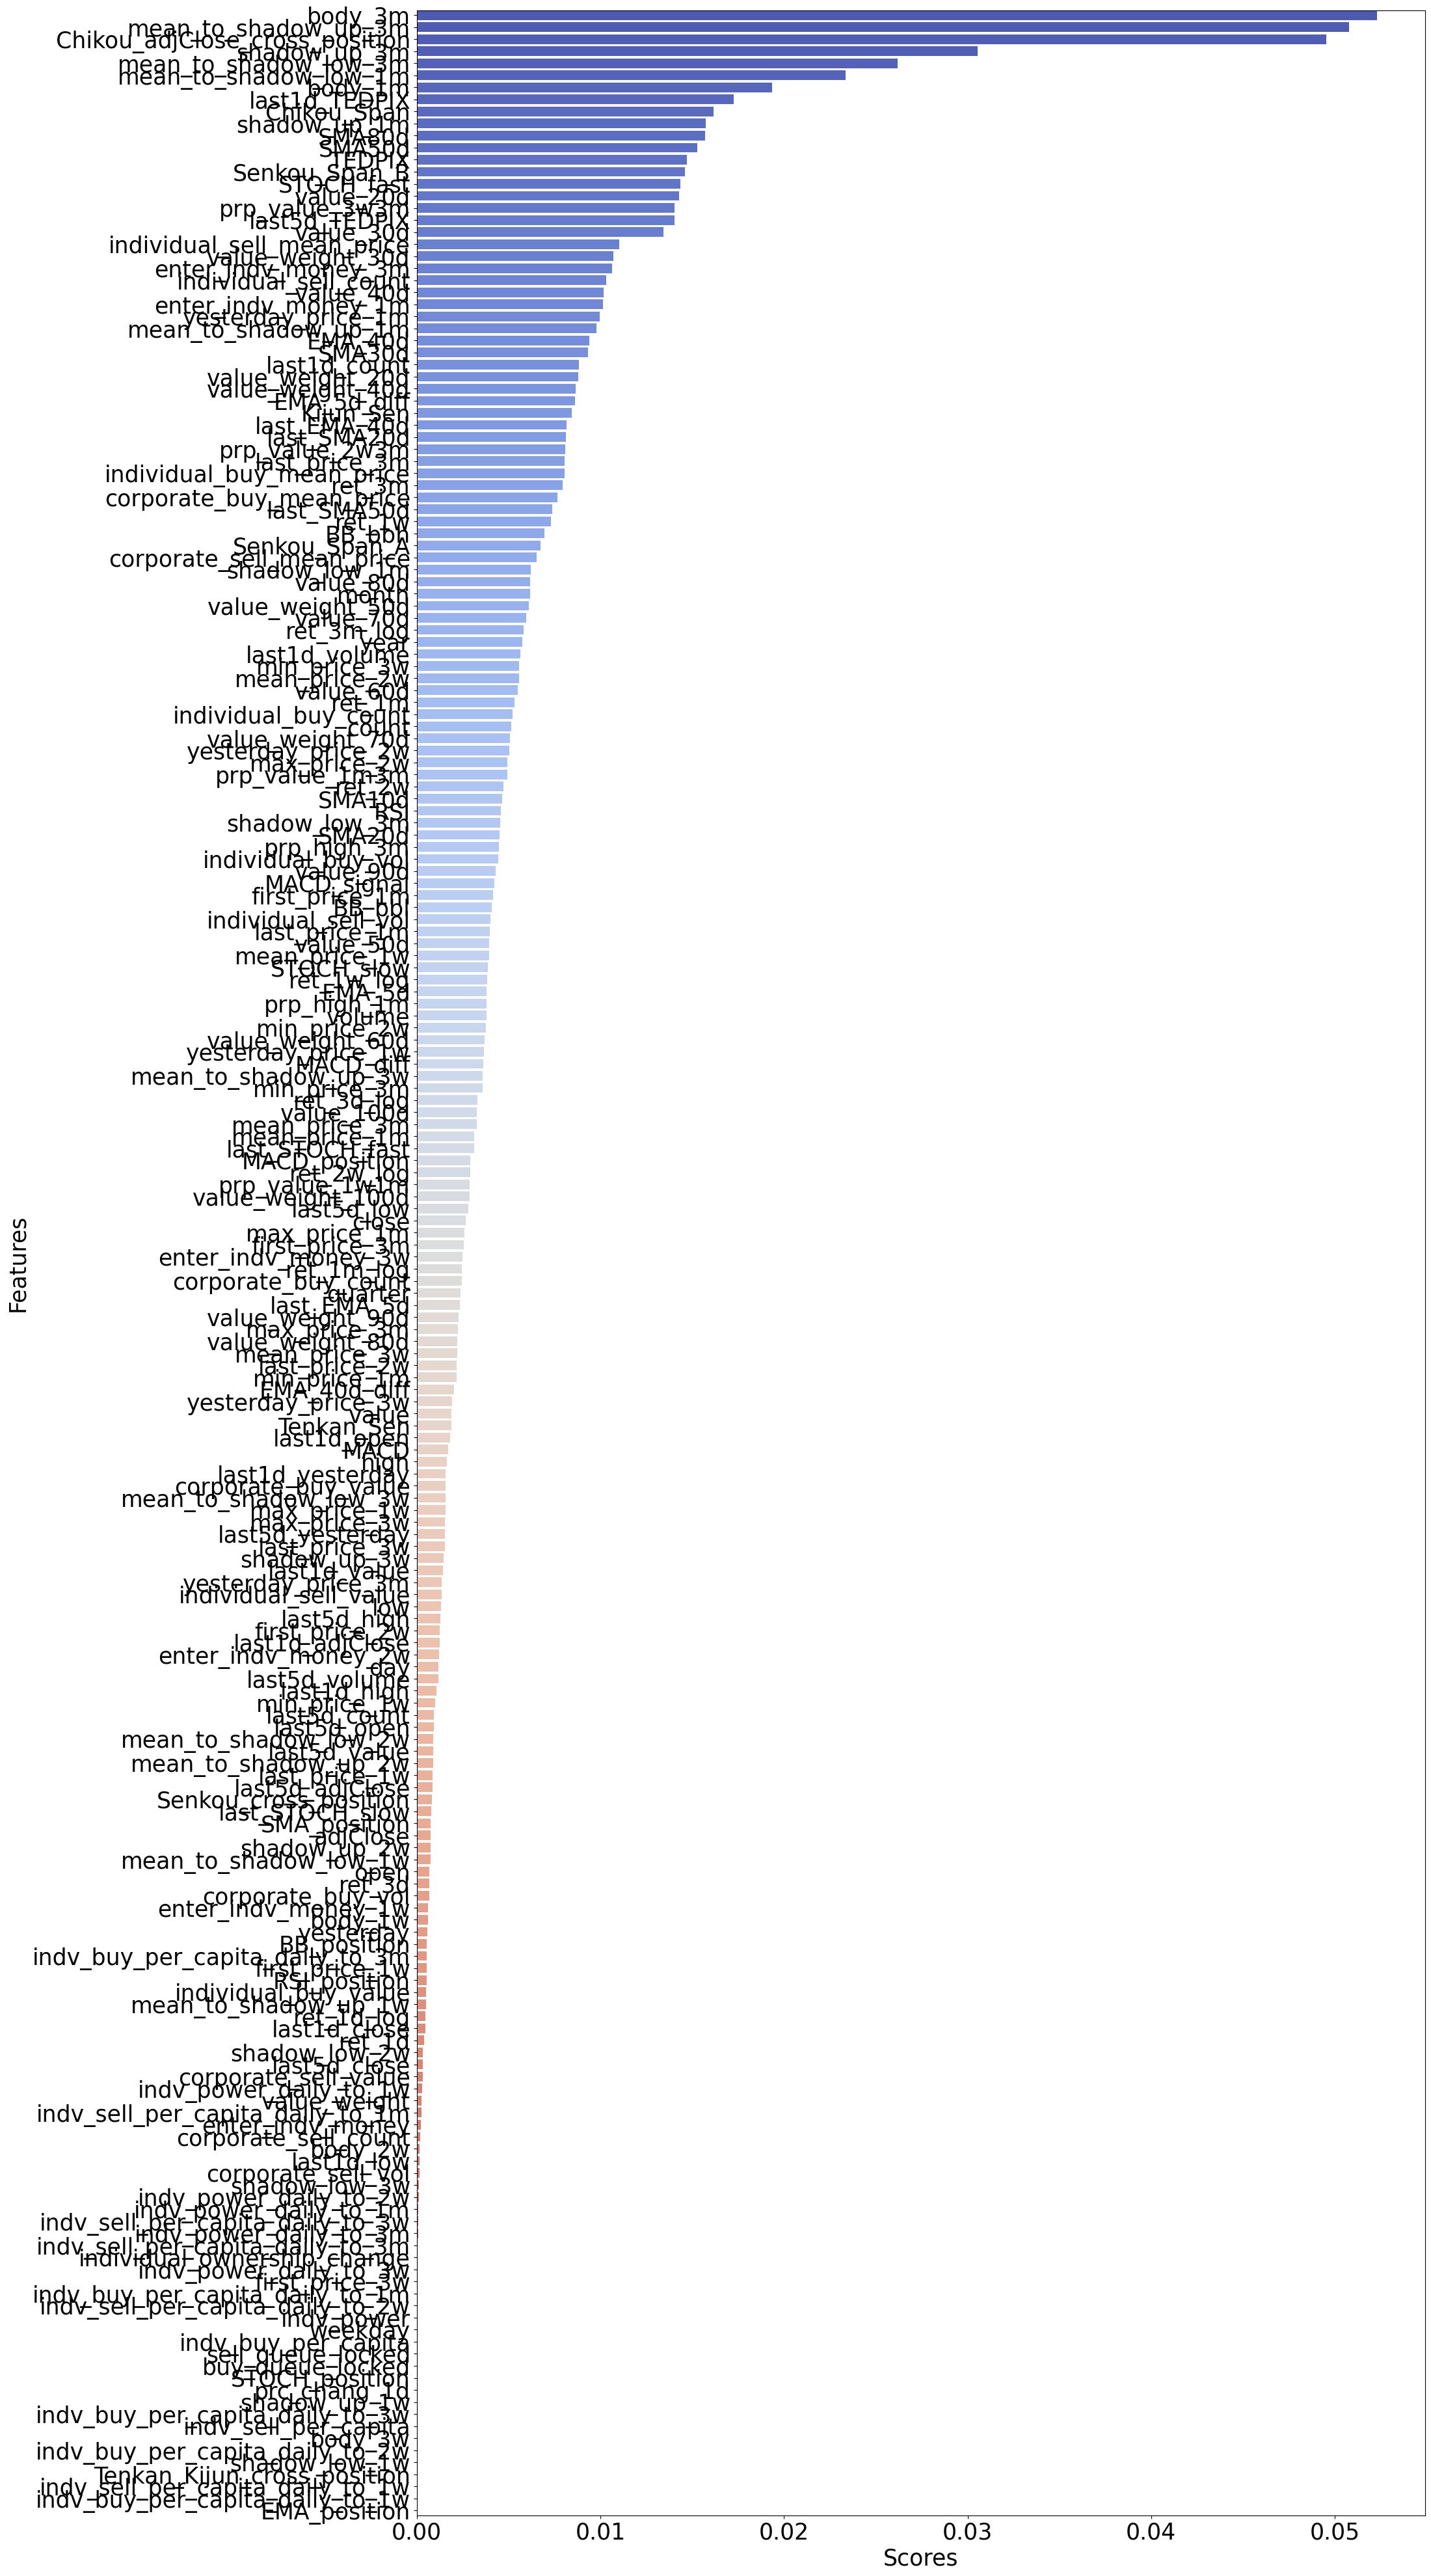

In [73]:
importance = pd.DataFrame(
    {
        'Features': init_features.iloc[:, 2:-3].columns,
        'Scores': featureImport
    }
).sort_values(by = ['Scores'], ascending = False)

plt.figure(figsize = (20, 50))
plt.tight_layout()

sns.barplot(
    data = importance,
    y = 'Features',
    x = 'Scores',
    palette = sns.color_palette('coolwarm', len(importance))
)
plt.margins(y = 0)

In [74]:
init_features['pred_cat_label'] = label_df['pred_cat_label']
init_features['label01'] = init_features['cat_label'].apply(
    lambda x: 1 if x == 'buy' else 0
)
init_features['pred_label01'] = label_df['pred_cat_label'].apply(
    lambda x: 1 if x == 'buy' else 0
)

init_features

,jdate,date,open,high,low,adjClose,value,volume,count,yesterday,close,TEDPIX,year,quarter,month,day,weekday,shadow_up_1w,shadow_low_1w,body_1w,mean_to_shadow_up_1w,mean_to_shadow_low_1w,shadow_up_2w,shadow_low_2w,body_2w,mean_to_shadow_up_2w,mean_to_shadow_low_2w,shadow_up_3w,shadow_low_3w,body_3w,mean_to_shadow_up_3w,mean_to_shadow_low_3w,shadow_up_1m,shadow_low_1m,body_1m,mean_to_shadow_up_1m,mean_to_shadow_low_1m,shadow_up_3m,shadow_low_3m,body_3m,mean_to_shadow_up_3m,mean_to_shadow_low_3m,max_price_1w,min_price_1w,mean_price_1w,first_price_1w,last_price_1w,yesterday_price_1w,max_price_2w,min_price_2w,mean_price_2w,first_price_2w,last_price_2w,yesterday_price_2w,max_price_3w,min_price_3w,mean_price_3w,first_price_3w,last_price_3w,yesterday_price_3w,max_price_1m,min_price_1m,mean_price_1m,first_price_1m,last_price_1m,yesterday_price_1m,max_price_3m,min_price_3m,mean_price_3m,first_price_3m,last_price_3m,yesterday_price_3m,prp_high_1m,prp_high_3m,prp_value_1w1m,prp_value_2w3m,prp_value_3w3m,prp_value_1m3m,prc_chang_1d,ret_1d,ret_3d,ret_1w,ret_2w,ret_1m,ret_3m,ret_1d_log,ret_3d_log,ret_1w_log,ret_2w_log,ret_1m_log,ret_3m_log,buy_queue_locked,sell_queue_locked,last1d_open,last1d_high,last1d_low,last1d_adjClose,last1d_value,last1d_volume,last1d_count,last1d_yesterday,last1d_close,last1d_TEDPIX,last5d_open,last5d_high,last5d_low,last5d_adjClose,last5d_value,last5d_volume,last5d_count,last5d_yesterday,last5d_close,last5d_TEDPIX,value_20d,value_30d,value_40d,value_50d,value_60d,value_70d,value_80d,value_90d,value_100d,value_weight,value_weight_20d,value_weight_30d,value_weight_40d,value_weight_50d,value_weight_60d,value_weight_70d,value_weight_80d,value_weight_90d,value_weight_100d,BB_bbh,BB_bbl,BB_position,Tenkan_Sen,Kijun_Sen,Chikou_Span,Senkou_Span_A,Senkou_Span_B,Tenkan_Kijun_cross_position,Senkou_cross_position,Chikou_adjClose_cross_position,EMA_5d,EMA_5d_diff,last_EMA_5d,EMA_40d,EMA_40d_diff,last_EMA_40d,EMA_position,MACD,MACD_diff,MACD_signal,MACD_position,SMA10d,SMA20d,last_SMA20d,SMA30d,SMA50d,last_SMA50d,SMA80d,SMA_position,STOCH_fast,STOCH_slow,last_STOCH_fast,last_STOCH_slow,STOCH_position,RSI,RSI_position,individual_buy_count,corporate_buy_count,individual_sell_count,corporate_sell_count,individual_buy_vol,corporate_buy_vol,individual_sell_vol,corporate_sell_vol,individual_buy_value,corporate_buy_value,individual_sell_value,corporate_sell_value,individual_buy_mean_price,individual_sell_mean_price,corporate_buy_mean_price,corporate_sell_mean_price,individual_ownership_change,enter_indv_money,indv_buy_per_capita,indv_sell_per_capita,indv_power,enter_indv_money_1w,indv_buy_per_capita_daily_to_1w,indv_sell_per_capita_daily_to_1w,indv_power_daily_to_1w,enter_indv_money_2w,indv_buy_per_capita_daily_to_2w,indv_sell_per_capita_daily_to_2w,indv_power_daily_to_2w,enter_indv_money_3w,indv_buy_per_capita_daily_to_3w,indv_sell_per_capita_daily_to_3w,indv_power_daily_to_3w,enter_indv_money_1m,indv_buy_per_capita_daily_to_1m,indv_sell_per_capita_daily_to_1m,indv_power_daily_to_1m,enter_indv_money_3m,indv_buy_per_capita_daily_to_3m,indv_sell_per_capita_daily_to_3m,indv_power_daily_to_3m,pivot,weight,cat_label,pred_cat_label,label01,pred_label01
0,1388-02-14,2009-05-04,14.0,15.0,14.0,15.0,3.759837e+09,2080737.0,204.0,15.0,15.0,8638.3,1388.0,1.0,2.0,14.0,2.0,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.000000,-0.066667,0.000000,0.000000,0.066667,0.00000,-0.066667,0.066667,-0.057576,0.075758,0.071429,0.000000,0.214286,-0.189223,0.096491,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.0,15.0,15.0,15.0,15.0,14.0,15.000000,15.0,15.0,15.0,16.0,14.0,15.136364,15.0,16.0,15.0,18.0,14.0,15.350877,14.0,17.0,14.0,1.071429,1.071429,0.349193,0.253204,0.326386,0.327252,0.0,0.000000,0.000000,0.000000,0.000000,0.004762,-0.045133,0.000000,0.000000,0.000000,0.000000,0.000000,-0.064539,0.0,0.0,15.0,15.0,14.0,15.0,2.382522e+09,1358340.0,147.0,15.0,14.0,8584.6,15.0,15.0,15.0,15.0,1.460205e+09,815360.0,122.0,15.0,1

Max return in train section based on zigzag: 6760%
Max return in test section based on zigzag: 1064%
Return in passive invesitng in train section: 6040%
Return in passive invesitng in test section: 709%
Return in train section based on prediction: 6887%
Return in test section based on prediction: 342%


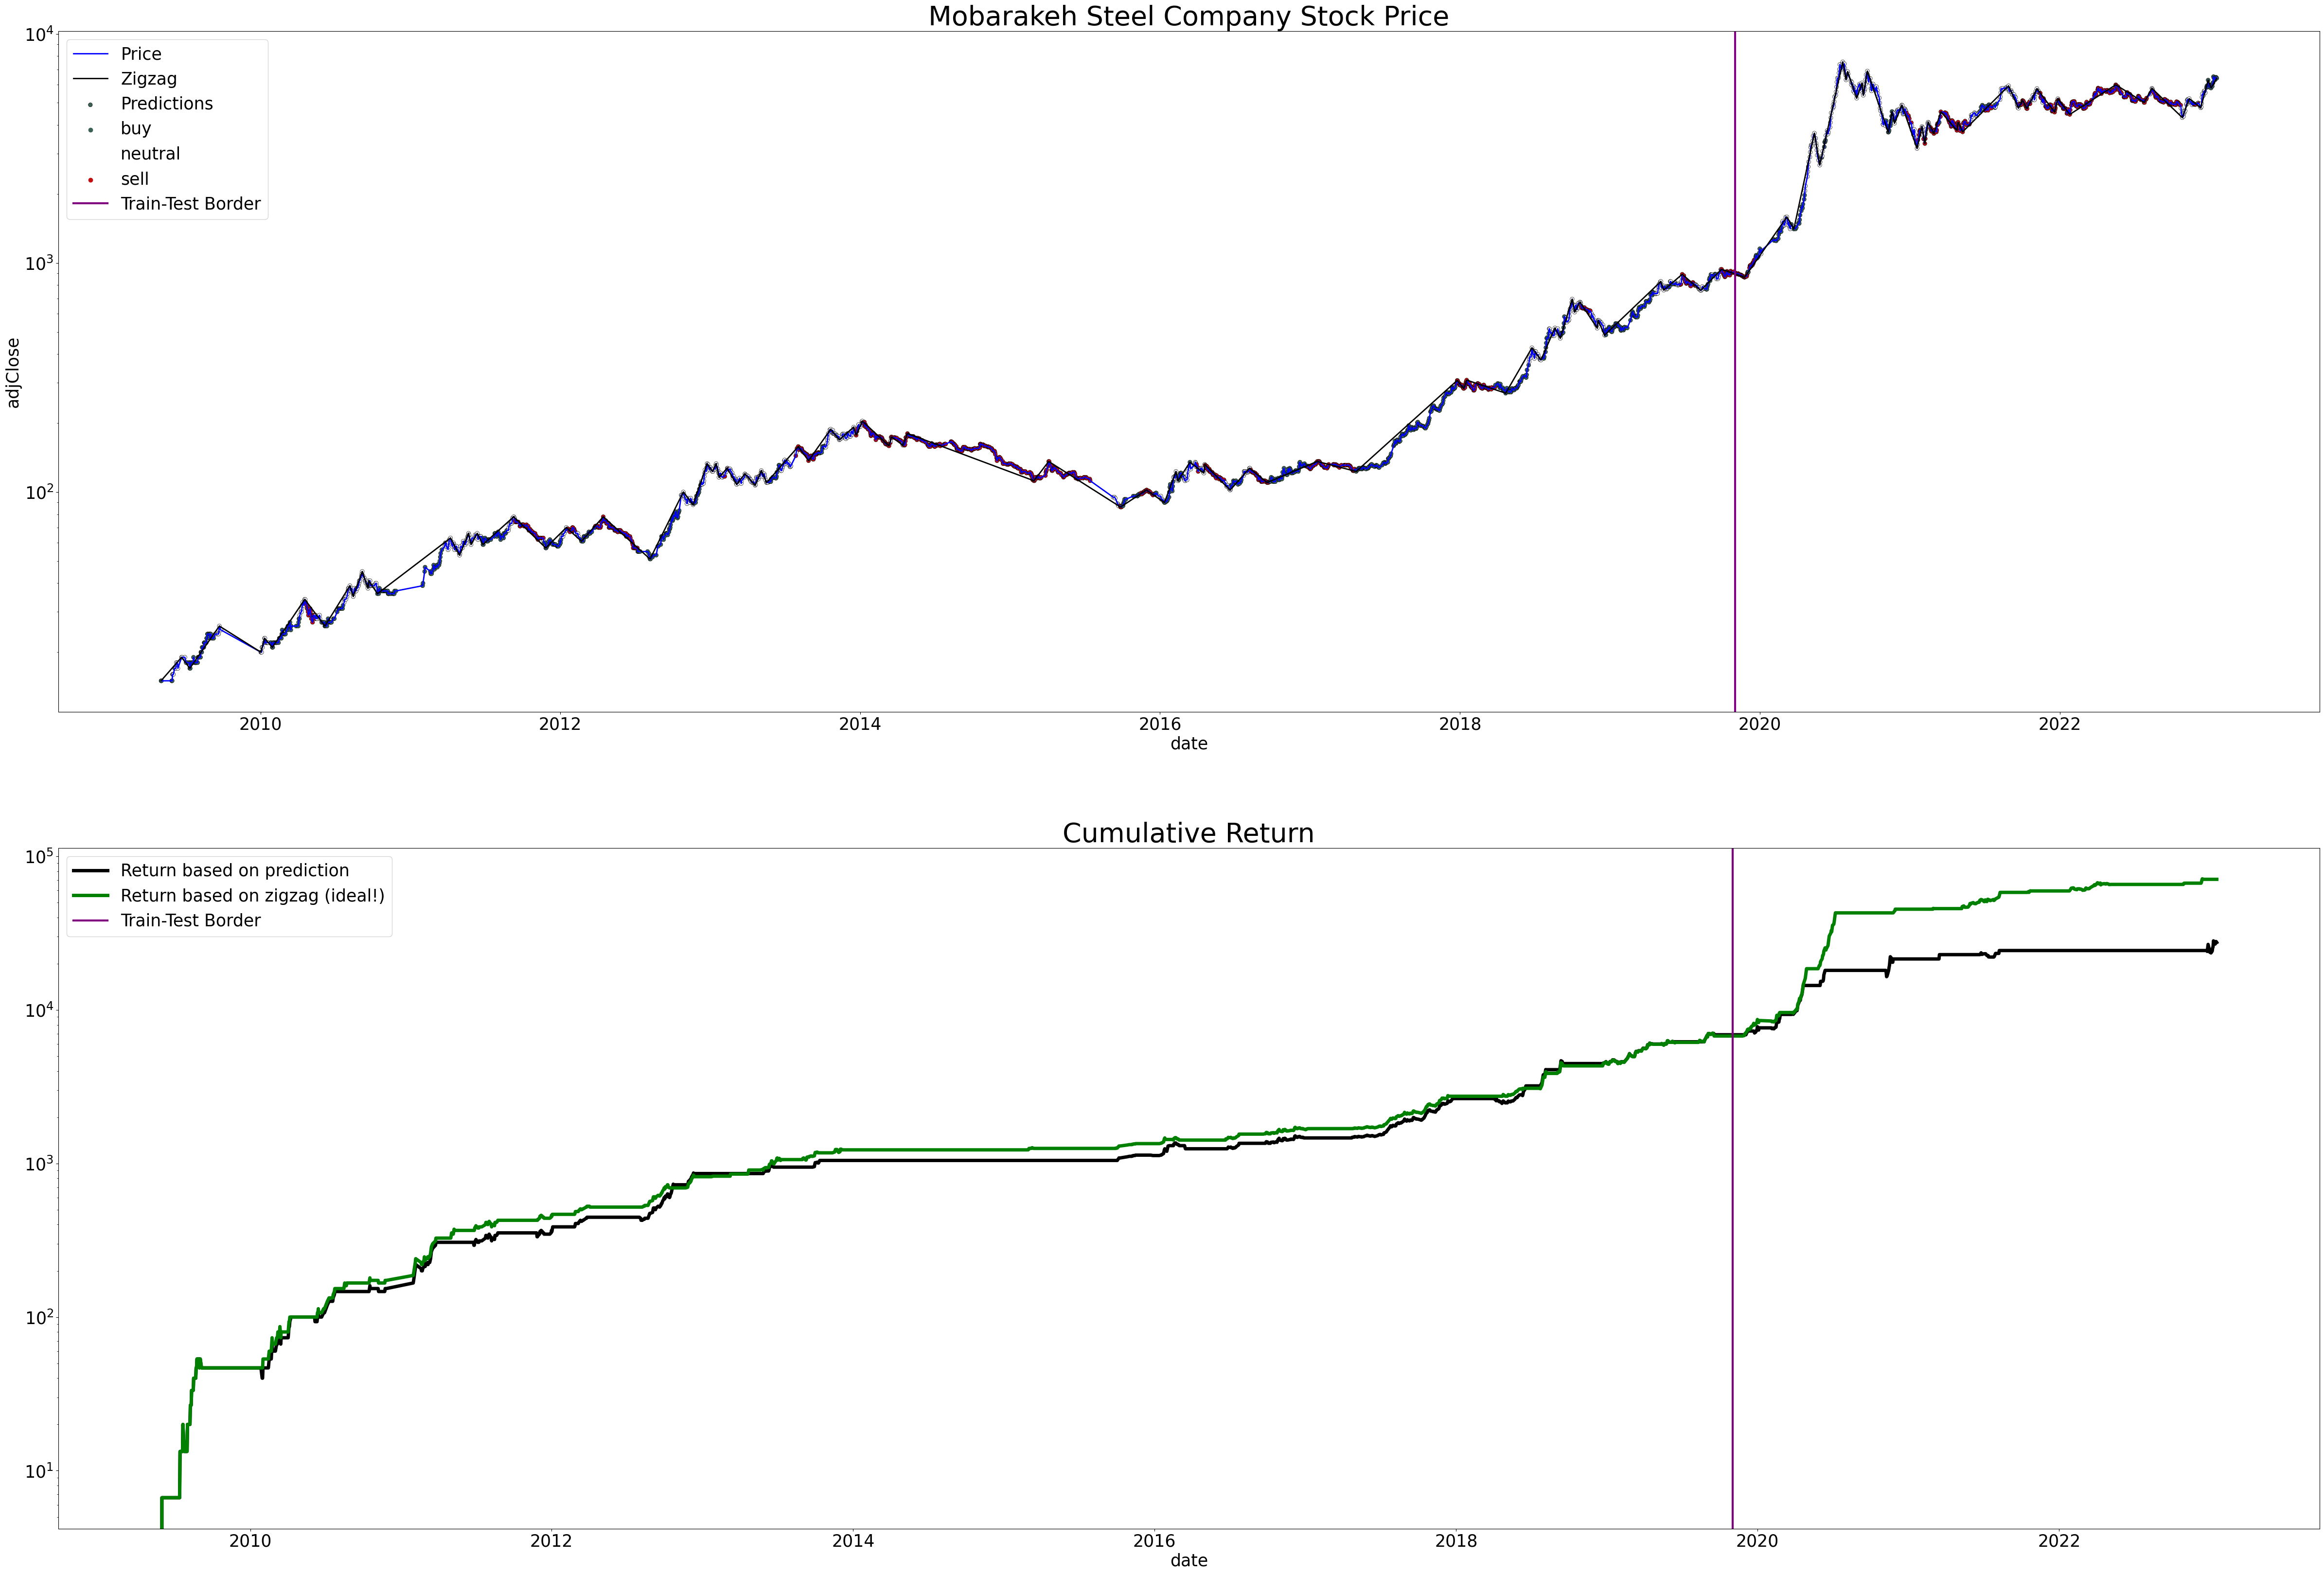

In [75]:
def plotLabel(df, trainPred, testPred):
    
    palette = {
        'buy': '#3C6255', 
        'neutral': '#ffffff', 
        'sell': '#C21010', 
        'pivot': '#F49D1A'
    }
    plt.rcParams.update({'font.size': 25})

    plt.figure(figsize = (60, 40))

    plt.subplot(2, 1, 1)
    plt.title('Mobarakeh Steel Company Stock Price', fontsize = 40)
    sns.lineplot(
        data = df,
        x = 'date',
        y = 'adjClose',
        color = 'blue',
        linewidth = 2,
        label = 'Price'
    )    
    sns.lineplot(
        x = df[df['pivot'] != 0]['date'], 
        y = df[df['pivot'] != 0]['adjClose'],
        color = 'black',
        linewidth = 2,
        label = 'Zigzag'
    )
    sns.scatterplot(
        data = df,
        x = 'date',
        y = 'adjClose',
        hue = 'pred_cat_label',
        palette = palette,
        edgecolor = 'black',
        label = 'Predictions'
    )
    plt.axvline(
        x = init_features['date'].iloc[len(trainPred) - 1],
        color = 'purple', 
        label = 'Train-Test Border',
        linewidth = 3
    )
    plt.yscale('log')
    plt.legend()

    plt.subplot(2, 1, 2)

    plt.title('Cumulative Return', fontsize = 40)

    sns.lineplot(
        data = df,
        x = 'date', 
        y = ((init_features['prc_chang_1d'] * init_features['pred_label01'].shift(2)).cumsum() / init_features['adjClose'].iloc[0]) * 100,
        color = 'black',
        linewidth = 5,
        label = 'Return based on prediction'
    )
    sns.lineplot(
        data = df,
        x = 'date', 
        y = ((init_features['prc_chang_1d'] * init_features['label01'].shift(2)).cumsum() / init_features['adjClose'].iloc[0]) * 100,
        color = 'green',
        linewidth = 5,
        label = 'Return based on zigzag (ideal!)'
    )
    plt.axvline(
        x = init_features['date'].iloc[len(trainPred) - 1],
        color = 'purple', 
        label = 'Train-Test Border',
        linewidth = 3
    )

    plt.yscale('log')
    plt.legend()

    plt.subplots_adjust(
        wspace = 0.2,
        hspace = 0.2
    )

    plt.savefig(
        'price_plot.png',
        format = 'png',
        dpi = 216
    )

plotLabel(init_features, trainPred, testPred)

print(f'Max return in train section based on zigzag: {((init_features["prc_chang_1d"] * init_features["label01"].shift(2)).iloc[:len(trainPred)].sum() / init_features["adjClose"].iloc[0]):0.0%}')
print(f'Max return in test section based on zigzag: {((init_features["prc_chang_1d"] * init_features["label01"].shift(2)).iloc[len(trainPred):].sum() / init_features["adjClose"].iloc[len(trainPred)]):0.0%}')

print(f'Return in passive invesitng in train section: {(init_features["adjClose"].iloc[len(trainPred) - 1]  / init_features["adjClose"].iloc[0]):0.0%}')
print(f'Return in passive invesitng in test section: {(init_features["adjClose"].iloc[-1]  / init_features["adjClose"].iloc[len(trainPred)]):0.0%}')

print(f'Return in train section based on prediction: {((init_features["prc_chang_1d"] * init_features["pred_label01"].shift(2)).iloc[:len(trainPred)].sum() / init_features["adjClose"].iloc[0]):0.0%}')
print(f'Return in test section based on prediction: {((init_features["prc_chang_1d"] * init_features["pred_label01"].shift(2)).iloc[len(trainPred):].sum() / init_features["adjClose"].iloc[len(trainPred)]):0.0%}')